In [1]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(left = echonest_metrics, on='track_id', right = tracks[['track_id', 'genre_top']])

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [2]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


In [3]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

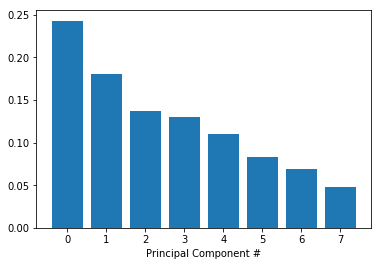

In [4]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
exp_variance

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

In [5]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance


array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

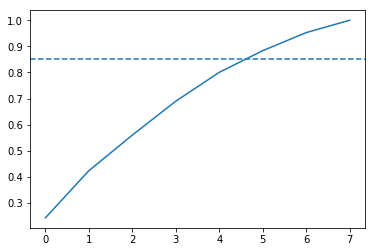

In [6]:
# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
plt.show()

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [7]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [8]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.66      0.66       229
        Rock       0.92      0.92      0.92       972

   micro avg       0.87      0.87      0.87      1201
   macro avg       0.79      0.79      0.79      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.57      0.65       229
        Rock       0.90      0.95      0.93       972

   micro avg       0.88      0.88      0.88      1201
   macro avg       0.83      0.76      0.79      1201
weighted avg       0.87      0.88      0.87      1201



/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(n= hop_only.shape[0], random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,
                                                                            labels,
                                                                            random_state=10)

In [10]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.77      0.77       230
        Rock       0.76      0.76      0.76       225

   micro avg       0.76      0.76      0.76       455
   macro avg       0.76      0.76      0.76       455
weighted avg       0.76      0.76      0.76       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.83      0.82       230
        Rock       0.82      0.81      0.82       225

   micro avg       0.82      0.82      0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv = kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),
      "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7241758241758242 Logistic Regression: 0.7752747252747252


/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/suheylgurbuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau